In [ ]:
import os
os.chdir("Art-Valuation-in-Auction")


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from Models_res_connections.Utils.PickleIO import *
pd.set_option('display.max_rows', 150)
from tqdm import tqdm

In [ ]:
auction_results = read_list_of_dicts_from_appended_pickle('Datasets/auction_results_cleaned.pickle')
artists_details = read_list_of_dicts_from_appended_pickle('Datasets/artists_details.pickle')
auction_results_df = pd.DataFrame(auction_results)
artists_details_df = pd.DataFrame(artists_details)

auction_results_df['Sale Date Cleaned'] = pd.to_datetime(auction_results_df['Sale Date Cleaned'])

# Data Processing
* Year of Birth (done, transformed to Birth Period)
* Artist Country (done)
* Is Alive (done)
* Paint, Materials (done)
* Area (done)
* Sale Year (done)
* Sale Location (done)
* Auction House (done)
* Cumulative Auction Revenue (done)
* Average Auction Price Historically (done)
* Previously Bought In

#### Artists Details Cleaning & Merge to auction results

In [3]:
def clean_country_year(country_year):
    country, year = '', ''
    yob, yod = np.nan, np.nan

    country_year = re.split(',', country_year.strip(), maxsplit=1)
    if len(country_year) == 2:
        country, year = country_year
    elif len(country_year) == 1:
        if re.search(r'\d{2,}', country_year[0]):
            year = country_year[0]
        else:
            country = country_year[0]
    
    if ('-' in year) or ('–' in year):
        year = re.findall(r'(?:^|\D)(\d+)\s*[–\-]\s*(\d+)(?:$|\D)', year)
        if len(year) == 1:
            year = year[0]
            if len(year) == 2:
                yob, yod = year
                yob = int(yob) if len(yob) == 4 else np.nan
                yod = int(yod) if len(yod) == 4 else np.nan
        
    elif year != '':
        yob = re.findall(r'(?:^|\D)(\d{4})(?:\D|$)',year)
        yob = int(yob[0]) if len(yob) == 1 else np.nan
    
    return pd.Series([country, yob, yod])

artists_details_df[['Country','Year of Birth','Year of Death']] = artists_details_df['artist_country_year'].apply(clean_country_year)
artists_details_df['Country'] = artists_details_df['Country'].replace('','Unknown')

##### Year of Birth to Period

In [4]:
periods_year = [1400, 1600, 1750, 1850, 1950, 1970, 2025]
birth_periods = [f'before_{y}' for y in periods_year]
artists_details_df[birth_periods] = 0
for (i, y) in enumerate(periods_year):
    artists_details_df.loc[(artists_details_df['Year of Birth']<=y), birth_periods[i:]] = 1

In [5]:
auction_results_df = auction_results_df.merge(artists_details_df[['artist_id','Country','Year of Birth','Year of Death']+birth_periods], how='left', left_on='Artist ID', right_on='artist_id')
auction_results_df['Sale Year'] = auction_results_df['Sale Date Cleaned'].dt.year

#### Alive: Yes/No

Rule: 
* if both year of death and sale date available: 
    * `Alive_Yes = Sale Year < Year of Death`
    * `Alive_No = Sale Year > Year of Death`
* if sale date available:
    * if year of birth is available: 
        * `Alive_Yes = Sale Year < Year of Birth + 50`
        * `Alive_No = Sale Year > Year of Birth + 100`
* else:
    * `Alive_Yes = Alive_No = 0`

In [6]:
con1_yes = auction_results_df['Sale Year'] < auction_results_df['Year of Death']
con1_no = auction_results_df['Sale Year'] > auction_results_df['Year of Death']

con2_yes = auction_results_df['Year of Death'].isnull()&(auction_results_df['Sale Year'] < auction_results_df['Year of Birth'] + 50)
con2_no = auction_results_df['Year of Death'].isnull()&(auction_results_df['Sale Year'] > auction_results_df['Year of Birth'] + 100)

auction_results_df['Alive_Yes'] = 0
auction_results_df['Alive_No'] = 0

auction_results_df.loc[con1_yes|con2_yes, 'Alive_Yes'] = 1
auction_results_df.loc[con1_no|con2_no, 'Alive_No'] = 1

auction_results_df['Alive_Unknown'] = 1 - auction_results_df[['Alive_Yes','Alive_No']].sum(axis=1)

#### Area

* 98.75% have area information
* missing value: use median (for now)

In [7]:
auction_results_df['Area'] = auction_results_df['Area'].round(decimals=0)
auction_results_df['Area'] = auction_results_df['Area'].fillna(auction_results_df['Area'].median())
auction_results_df['Area_Log'] = np.log(auction_results_df['Area'])

#### Cumulative Sales

In [8]:
if os.path.exists('Datasets/hist_median_avail_dict.pickle'):
    hist_median_avail_dict = read_list_of_dicts_from_appended_pickle('Datasets/hist_median_avail_dict.pickle')
    hist_median_avail = pd.DataFrame(hist_median_avail_dict)
else:
    hist_median = auction_results_df[auction_results_df['Sale Date Cleaned'].notnull()].sort_values(by=['Artist ID','Sale Date Cleaned'])[['Artist ID','Sale Date Cleaned','Price Sold USD']].copy()
    hist_median.reset_index(drop=True, inplace=True)
    hist_median['Historical Median'] = None

    prev_aid = ''
    prev_date = pd.to_datetime('2030-01-01')
    prev_prices = []

    for i in tqdm(range(len(hist_median))):
        row = hist_median.iloc[i]
        if row['Artist ID'] != prev_aid:
            prev_prices = []
        else:
            if row['Sale Date Cleaned'] != prev_date:
                hist_median.iloc[i, -1] = np.nanmedian(prev_prices)
        
        prev_prices.append(row['Price Sold USD'])
        prev_aid = row['Artist ID']
        prev_date = row['Sale Date Cleaned']
    hist_median_avail = hist_median[hist_median['Historical Median'].notnull()].copy().reset_index(drop=True)

In [9]:
auction_results_df['Work Count'] = auction_results_df['Price Sold USD'].notnull().astype(int)
cum_sales = auction_results_df.groupby(['Artist ID','Sale Date Cleaned'], as_index=False)[['Price Sold USD','Work Count']].sum()
cum_sales = cum_sales.sort_values(by=['Artist ID','Sale Date Cleaned'])
cum_sales[['Cumulative Sales','Cumulative Auction Count']] = cum_sales.groupby('Artist ID')[['Price Sold USD','Work Count']].cumsum()
cum_sales['Cumulative Sales'] = cum_sales['Cumulative Sales'] - cum_sales['Price Sold USD']
cum_sales['Cumulative Auction Count'] = cum_sales['Cumulative Auction Count'] - cum_sales['Work Count']
cum_sales['Average Historical Price'] = cum_sales['Cumulative Sales']/cum_sales['Cumulative Auction Count']

In [10]:
auction_results_df = auction_results_df.drop('Work Count', axis=1)
auction_results_df = auction_results_df.merge(cum_sales.drop(['Price Sold USD','Work Count'], axis=1), how='left', left_on=['Artist ID','Sale Date Cleaned'], right_on=['Artist ID','Sale Date Cleaned'])
# auction_results_df = auction_results_df.merge(hist_median_avail.drop('Price Sold USD', axis=1), how='left', left_on=['Artist ID','Sale Date Cleaned'], right_on=['Artist ID','Sale Date Cleaned'])

#### Filter: 
<!-- * past 3 years auctions -->
* Year of Creation between 1945 and 1970 (Post War)

In [11]:
con = (auction_results_df['Year of Creation'].fillna('9999').astype(int)>=1945)&(auction_results_df['Year of Creation'].fillna('9999').astype(int)<=1970)
# con = (auction_results_df['Sale Date Cleaned'].dt.year>=2022)
auction_results_filtered = auction_results_df[con].reset_index(drop=True).copy()

#### Previously Bought In

In [12]:
con = auction_results_df['Title Cleaned'].str.strip().str.lower().isin(['untitled','n/a','sans titre','senza titolo',])==False
con = con&(auction_results_df['Sale Date Cleaned'].notnull())

auction_results_df['Year of Creation 2'] = auction_results_df['Year of Creation'].fillna(9999)
auction_history = auction_results_df[con].groupby(['Artist ID','Title Cleaned','Year of Creation 2','Area','Sale Date Cleaned'], as_index=False).agg({'Bought In':'sum', 'Title':'count'}).rename({'Title':'Work Count','Year of Creation 2':'Year of Creation'}, axis=1)
auction_history = auction_history.sort_values(by=['Artist ID','Title Cleaned','Year of Creation','Area','Sale Date Cleaned'])
auction_results_df.drop('Year of Creation 2', axis=1, inplace=True)

auction_history['Bought In'] = (auction_history['Bought In']/auction_history['Work Count']).round(decimals=0)
auction_history[['Prev Artist ID','Prev Title Cleaned','Prev Year of Creation','Prev Area','Prev Sale Date Cleaned','Prev Bought In']] = auction_history[['Artist ID','Title Cleaned','Year of Creation','Area','Sale Date Cleaned','Bought In']].shift(1)

In [13]:
same_artwork = (auction_history['Prev Artist ID']==auction_history['Artist ID'])
same_artwork = same_artwork&(auction_history['Prev Title Cleaned']==auction_history['Title Cleaned'])
same_artwork = same_artwork&(auction_history['Prev Year of Creation']==auction_history['Year of Creation'])
same_artwork = same_artwork&(auction_history['Prev Area']==auction_history['Area'])
auction_history['Repeated Sale'] = 0
auction_history.loc[same_artwork, 'Repeated Sale'] = 1

In [14]:
auction_results_filtered = auction_results_filtered.merge(
    auction_history.loc[auction_history['Repeated Sale']==1, ['Artist ID','Title Cleaned','Year of Creation','Area','Sale Date Cleaned','Prev Bought In','Repeated Sale']],
    how='left', left_on=['Artist ID','Title Cleaned','Year of Creation','Area','Sale Date Cleaned'], right_on=['Artist ID','Title Cleaned','Year of Creation','Area','Sale Date Cleaned']
    )
auction_results_filtered['Prev Bought In'] = auction_results_filtered['Prev Bought In'].fillna(0)
auction_results_filtered['Repeated Sale'] = auction_results_filtered['Repeated Sale'].fillna(0)
auction_results_filtered['Prev Unknown'] = 1 - auction_results_filtered['Repeated Sale']

#### Country of Birth -- Take top 40, including UNKNOWN (96% coverage)

In [15]:
country_summary = auction_results_filtered['Country'].value_counts().reset_index()
country_summary.columns = ['Country','count']
country_summary['Cover'] = country_summary['count'].cumsum()/len(auction_results_filtered)

In [16]:
con = auction_results_filtered['Country'].isin(country_summary.head(40)['Country'].tolist()) == False
auction_results_filtered.loc[con, 'Country'] = 'Others'

#### Paint
* 40% oil
* Top 30: ~= 85% cover

In [17]:
auction_results_filtered['Paint'] = auction_results_filtered['Paint'].fillna('unknown')
auction_results_filtered['Paint'] = auction_results_filtered['Paint'].replace('','unknown')
paint_summary = auction_results_filtered['Paint'].value_counts().reset_index()
paint_summary.columns = ['Paint','count']
paint_summary['Rank'] = range(len(paint_summary))
paint_summary['cover'] = paint_summary['count'].cumsum()/paint_summary['count'].sum()

In [18]:
con = auction_results_filtered['Paint'].isin(paint_summary.head(30)['Paint'].tolist())==False
auction_results_filtered.loc[con, 'Paint'] = 'Others'

#### Materials
* 35% canvas
* 25% paper
* Top 25: >90% cover

In [19]:
auction_results_filtered['Material'] = auction_results_filtered['Material'].fillna('unknown')
auction_results_filtered['Material'] = auction_results_filtered['Material'].replace('','unknown')
Material_summary = auction_results_filtered['Material'].value_counts().reset_index()
Material_summary.columns = ['Material','count']
Material_summary['Rank'] = range(len(Material_summary))
Material_summary['cover'] = Material_summary['count'].cumsum()/Material_summary['count'].sum()

In [20]:
con = auction_results_filtered['Material'].isin(Material_summary.head(25)['Material'].tolist())==False
auction_results_filtered.loc[con, 'Material'] = 'Others'

#### Sale Location

* 15% Paris
* 9% Unknown
* 9% New York
* Top 30: 75% cover

In [21]:
auction_results_filtered['Sale Location'] = auction_results_filtered['Sale Location'].str.strip().str.lower()
auction_results_filtered['Sale Location'] = auction_results_filtered['Sale Location'].replace('','unknown')
auction_results_filtered['Sale Location'] = auction_results_filtered['Sale Location'].replace('n/a','unknown')
sale_location = auction_results_filtered['Sale Location'].value_counts().reset_index()
sale_location.columns = ['Sale Location','count']
sale_location['Rank'] = range(len(sale_location))
sale_location['cover'] = sale_location['count'].cumsum()/sale_location['count'].sum()

In [22]:
con = auction_results_filtered['Sale Location'].isin(sale_location.head(35)['Sale Location'].tolist())==False
auction_results_filtered.loc[con, 'Sale Location'] = 'Others'

#### Auction House
* 15% christie's
* 8% sotheby's
* top 100: 80%

In [23]:
auction_results_filtered['Auction House'] = auction_results_filtered['Auction House'].replace('N/A','unknown')
auction_results_filtered['Auction House'] = auction_results_filtered['Auction House'].str.strip().str.lower()
auction_house = auction_results_filtered['Auction House'].value_counts().reset_index()
auction_house.columns = ['Auction House','count']
auction_house['Rank'] = range(len(auction_house))
auction_house['cover'] = auction_house['count'].cumsum()/auction_house['count'].sum()

In [24]:
con = auction_results_filtered['Auction House'].isin(auction_house.head(100)['Auction House'].tolist())==False
auction_results_filtered.loc[con, 'Auction House'] = 'Others'

#### CPI EU and CPI US
* CPI EU starts only from 1996. The earliest sale year in the filtered auction result is 1986 ==> manually set to 1

In [25]:
cpi_us = pd.read_csv('Datasets/cpi_us.csv', header=0, index_col=None)
cpi_us.columns = ['YEAR','CPI']
cpi_us = cpi_us[cpi_us['YEAR'] >= 1985]
cpi_us['CPI'] = cpi_us['CPI'].replace('–',np.nan).astype(float)

cpi_us_1996 = cpi_us.loc[cpi_us['YEAR']==1996, 'CPI'].iloc[0]
cpi_us['CPI'] = cpi_us['CPI']/cpi_us_1996

cpi_us_2024 = cpi_us.loc[cpi_us['YEAR']==2024, 'CPI'].iloc[0]

cpi_us.loc[cpi_us['YEAR']==2025, 'CPI'] = cpi_us_2024 * 1.026

auction_results_filtered['CPI_US'] = auction_results_filtered['Sale Date Cleaned'].dt.year.map(cpi_us.set_index('YEAR')['CPI'].to_dict())


# Modelling:
* repeated sales Vs all sales?

In [26]:
filter_con = auction_results_filtered['Sale Year'].notnull()
filter_con = filter_con & auction_results_filtered['Price Sold USD'].notnull()

col_modelling = birth_periods + ['Country','Alive_Yes','Alive_No','Paint','Material','Area_Log','CPI_US','Auction House','Sale Location',
                 'Cumulative Sales','Cumulative Auction Count','Average Historical Price','Price Sold USD',
                #  'Prev Bought In','Repeated Sale','Prev Unknown',
                 'Sale Year']
auction_results_modelling = auction_results_filtered.loc[filter_con, col_modelling].copy()

#### A few final processing:

In [27]:
# Historical Price -- convert to log scale
auction_results_modelling['Log Average Historical Price'] = np.log(auction_results_modelling['Average Historical Price'].fillna(1))
# Cumulative Sales -- convert to log scale
auction_results_modelling['Log Cumulative Sales'] = np.log(auction_results_modelling['Cumulative Sales'].replace(0,1))

auction_results_modelling.drop(['Cumulative Sales','Average Historical Price'], axis=1, inplace=True)

In [28]:
# one hot encoding
auction_results_modelling = pd.get_dummies(auction_results_modelling)
auction_results_modelling.drop(['Country_Others','Paint_Others','Material_Others','Auction House_Others','Sale Location_Others'], axis=1, inplace=True)

In [29]:
# Target:
auction_results_modelling['Log Price Sold USD'] = np.log(auction_results_modelling['Price Sold USD'])
auction_results_modelling['Diff Log Price'] = auction_results_modelling['Log Price Sold USD'] - auction_results_modelling['Log Average Historical Price']
auction_results_modelling.drop('Price Sold USD', axis=1, inplace=True)

#### filter out the "new" artists

In [30]:
auction_results_modelling = auction_results_modelling[auction_results_modelling['Log Cumulative Sales']>0]
auction_results_modelling.reset_index(drop=True, inplace=True)

#### Train Test Split

In [59]:
from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import r2_score, make_scorer
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt

In [60]:
con_train = auction_results_modelling['Sale Year'] <= 2014
con_val = (auction_results_modelling['Sale Year'] > 2014)&(auction_results_modelling['Sale Year'] <= 2018)
con_test = (auction_results_modelling['Sale Year'] > 2018)&(auction_results_modelling['Sale Year'] <= 2025)

In [61]:
train = auction_results_modelling[con_train].copy().drop('Sale Year', axis=1).reset_index(drop=True)
val = auction_results_modelling[con_val].copy().drop('Sale Year', axis=1).reset_index(drop=True)
test = auction_results_modelling[con_test].copy().drop('Sale Year', axis=1).reset_index(drop=True)

In [62]:
target_cols = ['Log Price Sold USD','Diff Log Price']

train_X = train.drop(target_cols, axis=1)
train_Y = train[target_cols].copy()

val_X = val.drop(target_cols, axis=1)
val_Y = val[target_cols].copy()

test_X = test.drop(target_cols, axis=1)
test_Y = test[target_cols].copy()

#### Model 1: modelling Log Price - Log Historical

In [63]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [64]:
target_col = 'Diff Log Price'

rf = RandomForestRegressor(n_estimators=800, max_depth=20, max_features=0.3)
rf.fit(train_X, train_Y[target_col])

RandomForestRegressor(max_depth=20, max_features=0.3, n_estimators=800)

In [70]:
# import pickle

# # Save
# with open('Model Checkpoints/all_data/RF_w_res.pkl', 'wb') as f:
#     pickle.dump(rf, f)

##### Evaluation

In [65]:
MODEL_NAME = 'RF_w_res'

In [66]:
val_Y_pred = rf.predict(val_X)
test_Y_pred = rf.predict(test_X)

In [67]:
def evaluation_summary(df_val, df_test, 
                       target_col_name, pred_col_name, 
                       fig_save_to = None,
                       clip_upper = 25, 
                       quantile_cutoffs=[6.796823718274855, 8.57866451350434, 11.118023371247016, 9999],
                       quantile_names = ['1 LOW','2 MID-LOW','3 MID-HIGH','4 HIGH']):
    
    df_val['delta_log'] = df_val[pred_col_name] - df_val[target_col_name]
    df_val['Price_ori'] = np.exp(df_val[target_col_name])
    df_val['delta_ori'] = np.exp(df_val[pred_col_name].clip(upper = clip_upper)) - df_val['Price_ori']
    df_val['delta_perc_ori'] = 100*df_val['delta_ori']/df_val['Price_ori']

    df_test['delta_log'] = df_test[pred_col_name] - df_test[target_col_name]
    df_test['Price_ori'] = np.exp(df_test[target_col_name])
    df_test['delta_ori'] = np.exp(df_test[pred_col_name].clip(upper = clip_upper)) - df_test['Price_ori']
    df_test['delta_perc_ori'] = 100*df_test['delta_ori']/df_test['Price_ori']

    for q, r in zip(reversed(quantile_cutoffs), reversed(quantile_names)):
        df_val.loc[df_val[target_col_name]<=q, 'RANGE'] = r
        df_test.loc[df_test[target_col_name]<=q, 'RANGE'] = r

    outlier_con_val = df_val[pred_col_name] > clip_upper
    outlier_con_test = df_test[pred_col_name] > clip_upper

    mae_log_val = mean_absolute_error(df_val.loc[~outlier_con_val, target_col_name], df_val.loc[~outlier_con_val,pred_col_name])
    mae_log_test = mean_absolute_error(df_test.loc[~outlier_con_test, target_col_name], df_test.loc[~outlier_con_test,pred_col_name])
    mae_ori_val = mean_absolute_error(df_val.loc[~outlier_con_val, 'Price_ori'], np.exp(df_val.loc[~outlier_con_val, 'Log Price Pred']))
    mae_ori_test = mean_absolute_error(df_test.loc[~outlier_con_test, 'Price_ori'], np.exp(df_test.loc[~outlier_con_test, 'Log Price Pred']))
    mae_summary = pd.DataFrame({'log scale':[mae_log_val, mae_log_test], 'original scale':[mae_ori_val, mae_ori_test]}, index=['validation','test'])

    val_eval = df_val[~outlier_con_val].groupby('RANGE').apply(
        lambda x: pd.Series(
            {
                'Average Price': x['Price_ori'].mean(),
                'MAE':mean_absolute_error(x['Price_ori'], np.exp(x['Log Price Pred'])),
                'MAE (log)':mean_absolute_error(x[target_col_name], x['Log Price Pred']),
                'Average Delta (%)': x['delta_perc_ori'].mean(),
                '+- 20%': (x['delta_perc_ori'].abs()<=20).mean(),
                '+- 50%': (x['delta_perc_ori'].abs()<=50).mean(),
                '+- 80%': (x['delta_perc_ori'].abs()<=80).mean(),
            }
        )
    )
    test_eval = df_test[~outlier_con_test].groupby('RANGE').apply(
        lambda x: pd.Series(
            {
                'Average Price': x['Price_ori'].mean(),
                'MAE':mean_absolute_error(x['Price_ori'], np.exp(x['Log Price Pred'])),
                'MAE (log)':mean_absolute_error(x[target_col_name], x['Log Price Pred']),
                'Average Delta (%)': x['delta_perc_ori'].mean(),
                '+- 20%': (x['delta_perc_ori'].abs()<=20).mean(),
                '+- 50%': (x['delta_perc_ori'].abs()<=50).mean(),
                '+- 80%': (x['delta_perc_ori'].abs()<=80).mean(),
            }
        )
    )

    sns.set_theme(style='white')

    fig, axes = plt.subplots(2, 2, figsize=(15, 15), sharey='row')
    sns.boxplot(data = df_val[~outlier_con_val], x = 'RANGE', y='delta_log', order=quantile_names, ax=axes[0,1])
    sns.boxplot(data = df_test[~outlier_con_test], x = 'RANGE', y='delta_log', order=quantile_names, ax=axes[0,0])
    axes[0,0].set_title('Test')
    axes[0,0].set_xlabel("")
    axes[0,0].set_ylabel("Prediction Errors of Log Price")
    axes[0,1].set_title('Validation')
    axes[0,1].set_xlabel("")

    df_val['delta_perc_ori_abs'] = df_val['delta_perc_ori'].abs()
    df_test['delta_perc_ori_abs'] = df_test['delta_perc_ori'].abs()
    sns.histplot(data = df_val[~outlier_con_val], x='delta_perc_ori_abs', hue='RANGE', hue_order=quantile_names, element='step', fill=False, cumulative=True, stat='probability', common_norm=False, ax=axes[1,1])
    sns.histplot(data = df_test[~outlier_con_test], x='delta_perc_ori_abs', hue='RANGE', hue_order=quantile_names, element='step', fill=False, cumulative=True, stat='probability', common_norm=False, ax=axes[1,0])
    axes[1,0].set_xlim([0,300])
    axes[1,0].set_xlabel("%Prediction Errors of Price")
    axes[1,0].set_ylabel("Cumulative Probability")
    axes[1,1].set_xlim([0,300])
    axes[1,1].set_xlabel("%Prediction Errors of Price")
    axes[1,0].grid(True)
    axes[1,1].grid(True)
    
    if fig_save_to:
        plt.savefig(fig_save_to)

    plt.show()

    return mae_summary, val_eval, test_eval, df_val, df_test

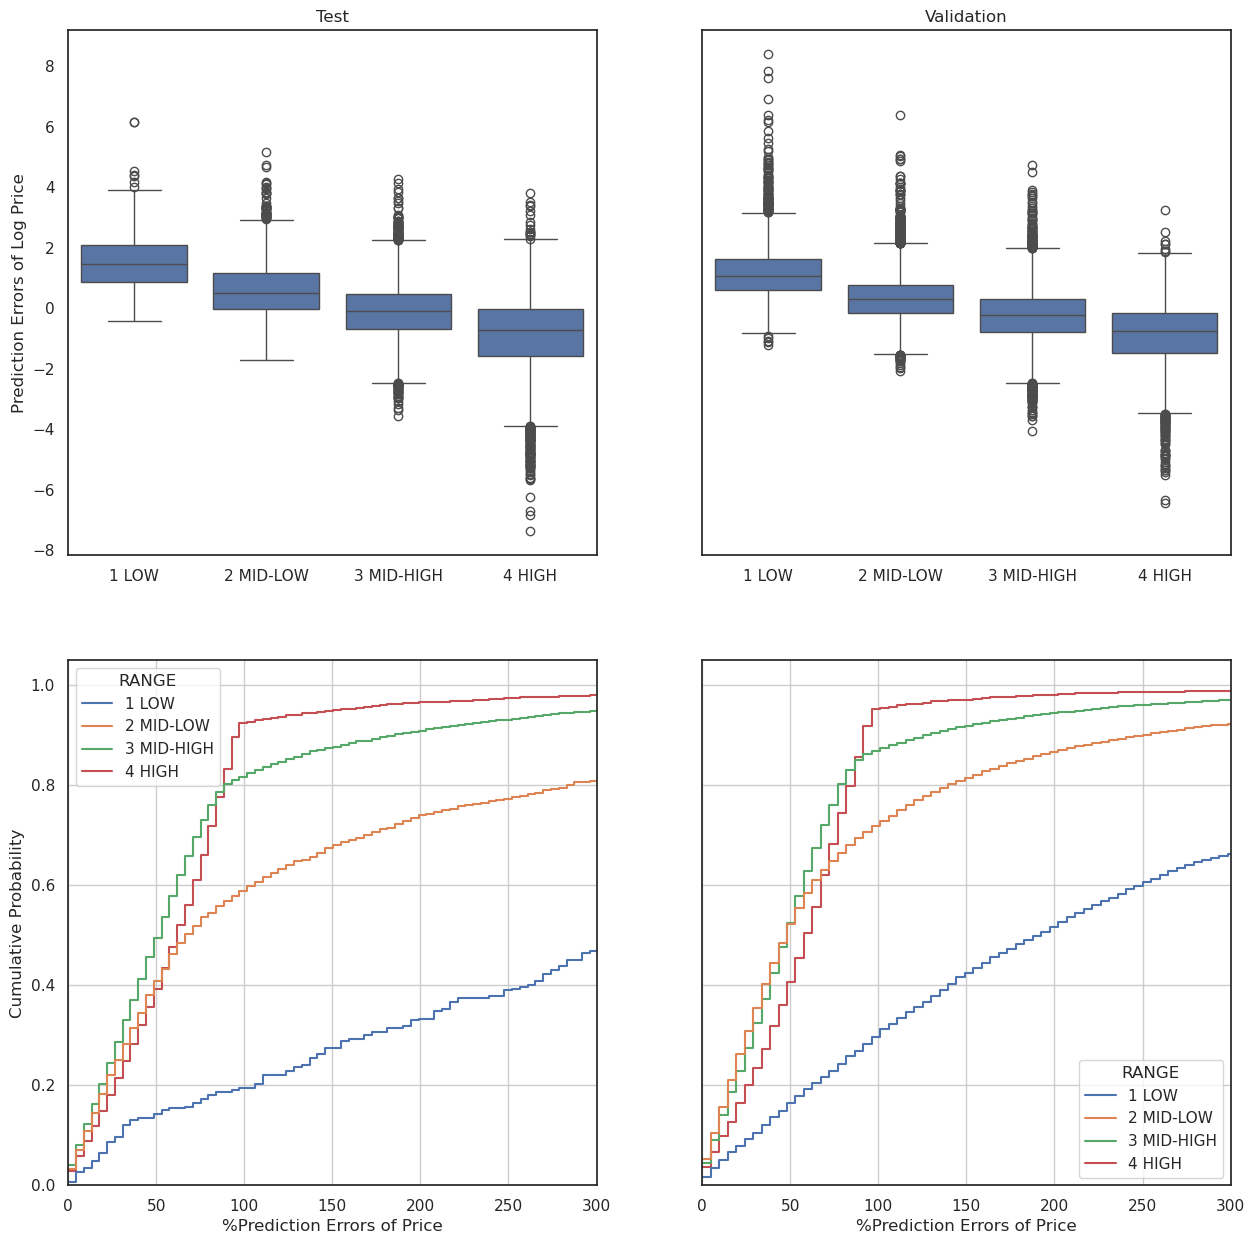

In [68]:
val['Log Price Pred'] = val_Y_pred + val['Log Average Historical Price']
test['Log Price Pred'] = test_Y_pred + test['Log Average Historical Price']

DATASET_FOLDER = 'dataprep_refined'

mae_summary, val_eval, test_eval, df_val, df_test = evaluation_summary(
    val, test, 'Log Price Sold USD', 'Log Price Pred',
    # fig_save_to = f'Models Evaluation/{DATASET_FOLDER}/{MODEL_NAME}/plots.png'
    )

In [69]:
val = df_val.copy()
test = df_test.copy()

del df_val, df_test

In [70]:
print(mae_summary)
print(val_eval)
print(test_eval)

            log scale  original scale
validation   0.782411    95138.792279
test         0.893179   331099.629072
            Average Price            MAE  MAE (log)  Average Delta (%)  \
RANGE                                                                    
1 LOW          529.861546    2151.315761   1.204367         745.233560   
2 MID-LOW     2612.254824    2891.701833   0.622258         111.526500   
3 MID-HIGH   20480.607860   14698.746579   0.701983          20.879703   
4 HIGH      980954.879379  786940.344460   1.083273         -30.464788   

              +- 20%    +- 50%    +- 80%  
RANGE                                     
1 LOW       0.067557  0.154637  0.238633  
2 MID-LOW   0.218488  0.499859  0.658948  
3 MID-HIGH  0.193733  0.494546  0.787916  
4 HIGH      0.133719  0.378617  0.719464  
            Average Price            MAE  MAE (log)  Average Delta (%)  \
RANGE                                                                    
1 LOW        6.134345e+02    3818.8

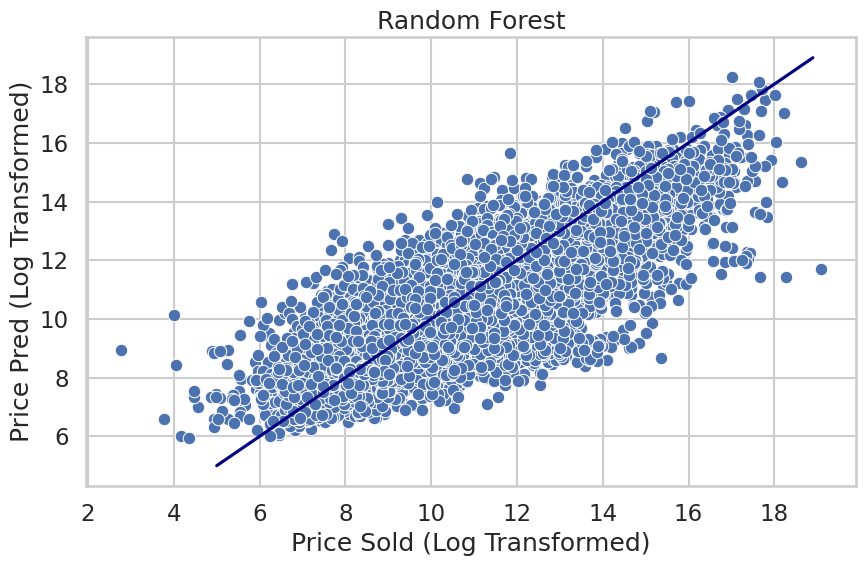

In [112]:
sns.set_theme('talk')
sns.set_style('whitegrid')
plt.figure(figsize=(9,6))
sns.scatterplot(data=test, x='Log Price Sold USD', y='Log Price Pred')
x_line = np.arange(5, 19, 0.1)
sns.lineplot(x=x_line, y=x_line, color = 'navy')
plt.xlabel('Price Sold (Log Transformed)')
plt.ylabel('Price Pred (Log Transformed)')
plt.title('Random Forest')
plt.tight_layout()

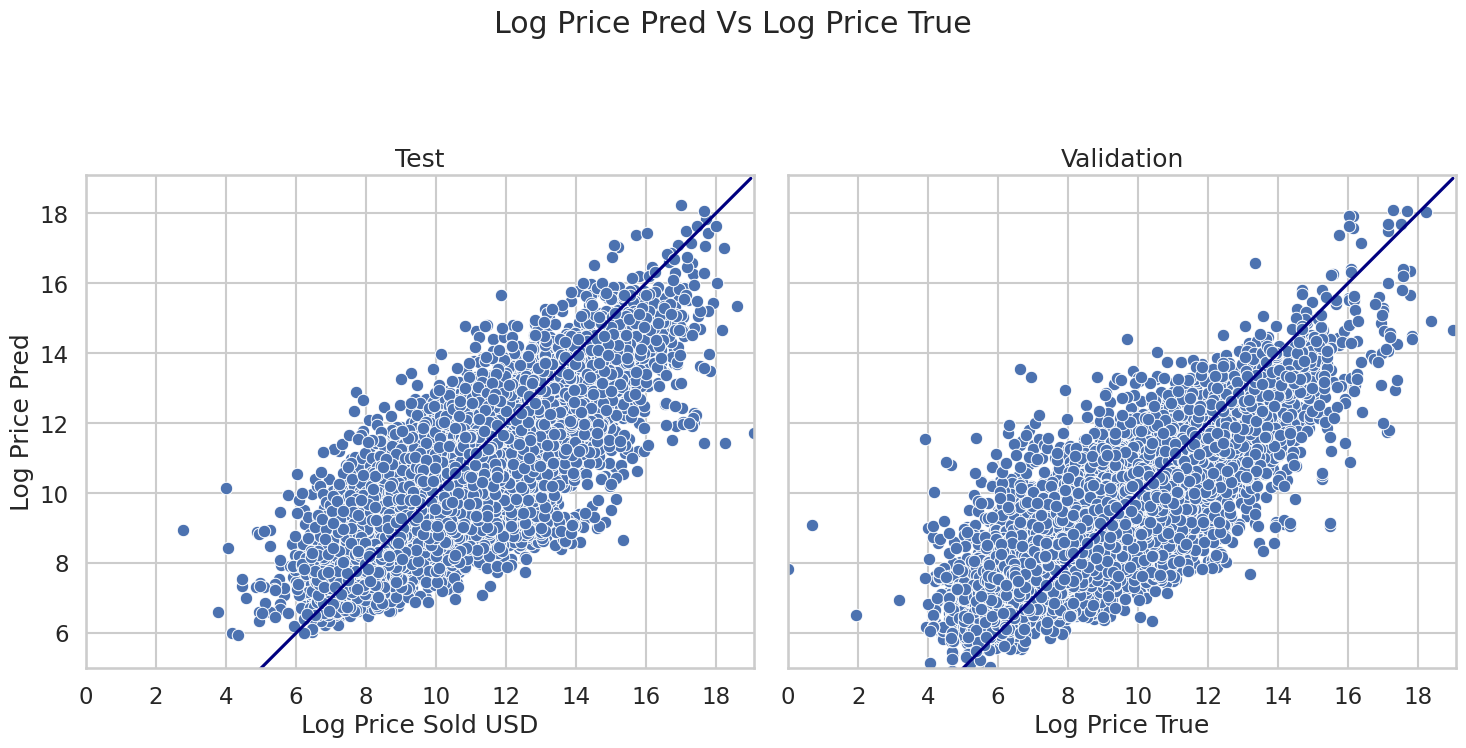

In [71]:
x_min = min(val['Log Price Sold USD'].min(), test['Log Price Sold USD'].min(), val['Log Price Pred'].min(), test['Log Price Pred'].min())
x_max = max(val['Log Price Sold USD'].max(), test['Log Price Sold USD'].max(), val['Log Price Pred'].max(), test['Log Price Pred'].max())

x_line = np.arange(x_min, x_max, 0.1)

sns.set_theme('talk')
sns.set_style('whitegrid')

fig, axes = plt.subplots(1, 2, figsize=(15, 8), sharey=True)
sns.scatterplot(data=val, x='Log Price Sold USD', y='Log Price Pred', ax=axes[1])
sns.lineplot(x=x_line, y=x_line, ax=axes[1], color = 'navy')
axes[0].set_title('Test')

sns.scatterplot(data=test, x='Log Price Sold USD', y='Log Price Pred', ax=axes[0])
sns.lineplot(x=x_line, y=x_line, ax=axes[0], color = 'navy')
axes[1].set_title('Validation')


for ax in axes:
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(5, x_max)
    ax.set_xticks(np.arange(x_min, x_max, 2))
    ax.set_aspect('equal')

# # plt.grid(True)
plt.xlabel('Log Price True')
plt.ylabel('Log Price Pred')
plt.suptitle('Log Price Pred Vs Log Price True')
plt.tight_layout()

# plt.savefig(f'Models Evaluation/{DATASET_FOLDER}/{MODEL_NAME}/True_v_Pred.png')

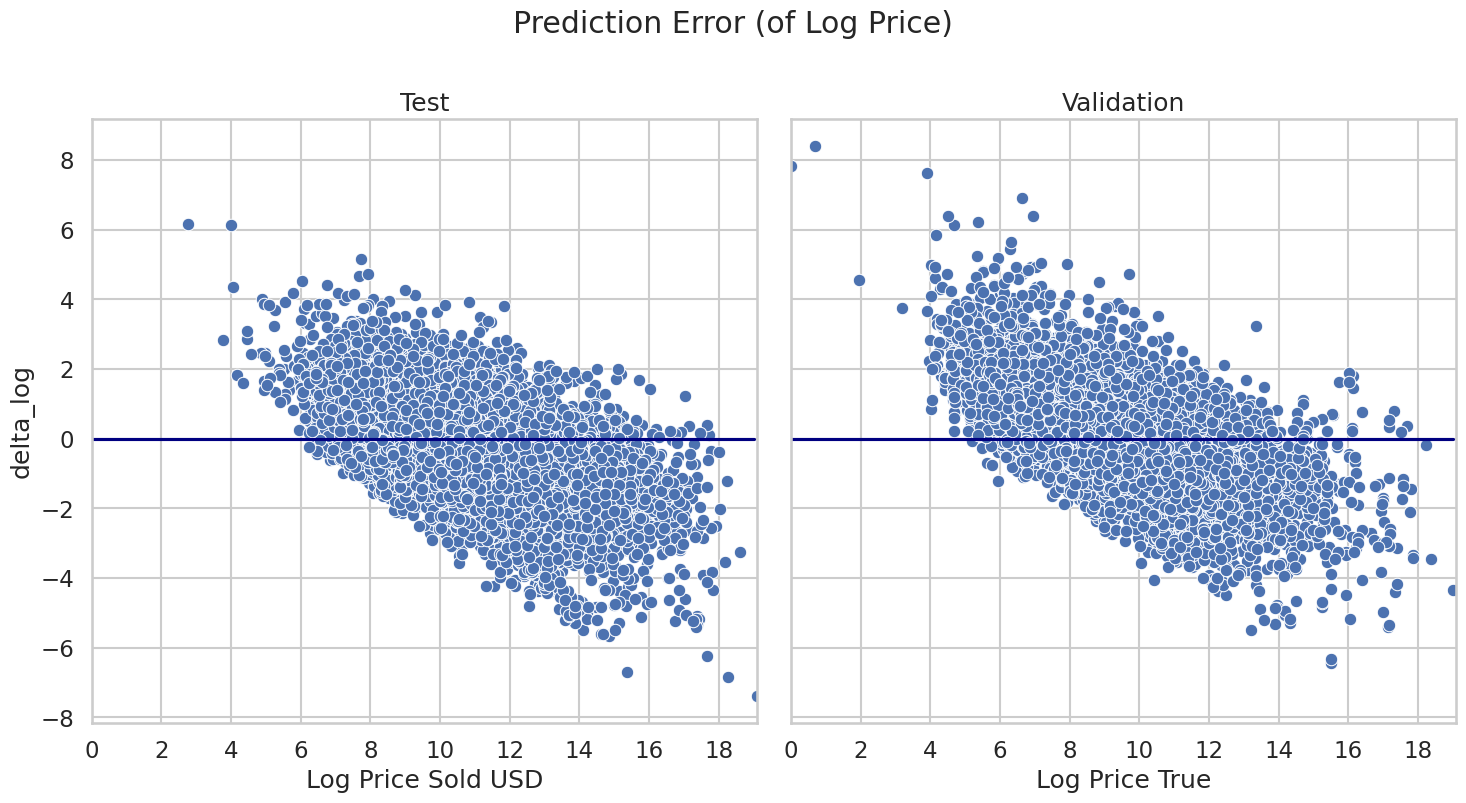

In [72]:
x_min = min(val['Log Price Sold USD'].min(), test['Log Price Sold USD'].min())
x_max = max(val['Log Price Sold USD'].max(), test['Log Price Sold USD'].max())

x_line = np.arange(x_min, x_max, 0.1)

sns.set_theme('talk')
sns.set_style('whitegrid')

fig, axes = plt.subplots(1, 2, figsize=(15, 8), sharey=True)

sns.scatterplot(data=val, x='Log Price Sold USD', y='delta_log', ax=axes[1])
sns.lineplot(x=x_line, y=[0]*len(x_line), ax=axes[1], color = 'navy')
axes[1].set_title('Validation')
# axes[0].set_aspect('equal')

sns.scatterplot(data=test, x='Log Price Sold USD', y='delta_log', ax=axes[0])
line_x = np.arange(test['Log Price Sold USD'].min(), test['Log Price Sold USD'].max(), 0.1)
sns.lineplot(x=x_line, y=[0]*len(x_line), ax=axes[0], color = 'navy')
axes[0].set_title('Test')
# axes[1].set_aspect('equal')

for ax in axes:
    ax.set_xlim(x_min, x_max)
    ax.set_aspect('equal')
    ax.set_xticks(np.arange(x_min, x_max, 2))

# # plt.grid(True)
plt.xlabel('Log Price True')
plt.ylabel('Error')
plt.suptitle('Prediction Error (of Log Price)')
plt.tight_layout()

# plt.savefig(f'Models Evaluation/{DATASET_FOLDER}/{MODEL_NAME}/Err_v_True.png')
plt.show()

In [85]:
model_metadata = {'Model': MODEL_NAME, 'DATATSET': DATASET_FOLDER, 'n_estimators':800, 'max_features':0.3, 'max_depth':20}

with open(f'Models Evaluation/{DATASET_FOLDER}/{MODEL_NAME}/Summary.html', 'w') as f:
    f.write(f"<h2>Metadata</h2><p>{model_metadata}</p>")
    f.write(f"<h2>MAE Summary</h2><p>{mae_summary.to_html(index=True)}</p>")
    f.write(f"<h2>Validation Evaluation</h2><p>{val_eval.to_html(index=True)}</p>")
    f.write(f"<h2>Test Evaluation</h2><p>{test_eval.to_html(index=True)}</p>")
    # f.write(f"<h2>Plot</h2><img src='plots.png'>")
    f.write(f"<h2>Plots</h2>")
    f.write(f"<img src='plots.png' style='width:600px'><br>")
    f.write(f"<img src='True_v_Pred.png' style='width:600px'><br>")
    f.write(f"<img src='Err_v_True.png' style='width:600px'><br>")

In [73]:
import shap

shap.initjs()

/userdata/xueqwang/miniconda3/envs/py_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
train_sample = 500
val_sample = 100
explainer = shap.TreeExplainer(rf)
val_sample = val.drop(['Log Price Sold USD','Diff Log Price','Log Price Pred','delta_log','Price_ori','delta_ori','delta_perc_ori','RANGE','delta_perc_ori_abs'], axis=1).sample(n=val_sample, random_state=0)
feature_names = val_sample.columns.tolist()

shap_values = explainer.shap_values(val_sample)

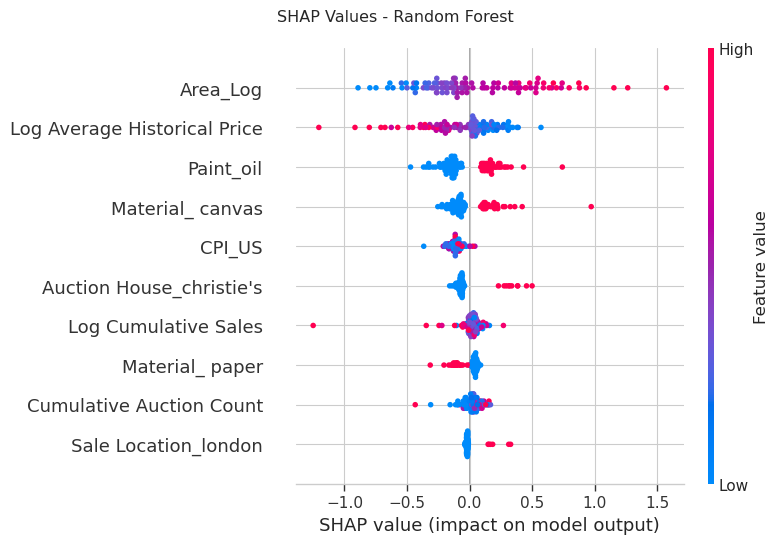

In [107]:
sns.set_theme('paper')
sns.set_style('whitegrid')
shap.summary_plot(shap_values, val_sample, feature_names=feature_names, max_display=10, show=False)
plt.suptitle("SHAP Values - Random Forest")
plt.tight_layout()
plt.show()

In [ ]:
groups = []
group_names = []
used = set()


for prefix in ['Country','Paint','Material','Auction House','Sale Location']:
    matching = [i for i, f in enumerate(feature_names) if f.startswith(prefix+'_')]
    if matching:
        groups.append(matching)
        group_names.append(prefix)
        used.update(matching)
for i, f in enumerate(feature_names):
    if i not in used:
        groups.append([i])
        group_names.append(f)
grouped_shap_values = shap.Explanation(
    values = np.stack([shap_values[:, g].sum(axis=1) for g in groups], axis=1),
    base_values = explainer.expected_value,
    data = np.stack([val_sample.iloc[:, g].sum(axis=1) if len(g)>1 else val_sample.iloc[:, g[0]] for g in groups], axis=1),
    feature_names=group_names
)
shap.plots.beeswarm(grouped_shap_values)

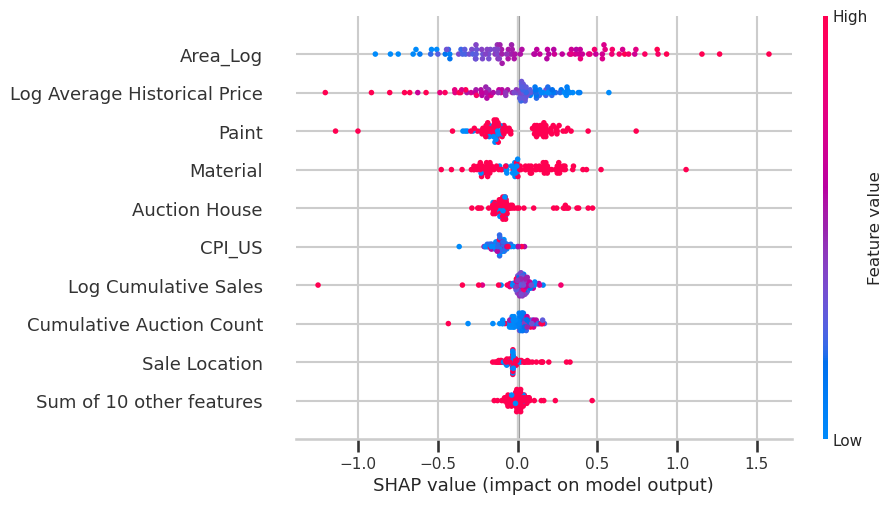